In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from __future__ import print_function
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pickle
import random
import math
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from PIL import Image
import os
import copy as cp
import multi_loss_model as mlmodel

In [3]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

## set up

#### check and set gpu

In [4]:
torch.cuda.empty_cache()

In [5]:
torch.cuda.is_available()

True

In [5]:
if torch.cuda.device_count()>1:
    #torch.cuda.device(1)
    torch.cuda.set_device(0)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [6]:
#device="cpu"

In [7]:
print(torch.cuda.current_device())

0


#### load and process data

In [8]:
with open('train+val_data.pickle', 'rb') as handle:
    all_data = pickle.load(handle)

In [9]:
len(all_data)

61344

In [11]:
all_data[0]

{'filename': 'n015-2018-09-25-13-17-43+0800__CAM_FRONT_RIGHT__1537852872520339',
 'box': [193.53250468896272,
  430.37026586022426,
  249.4967302236848,
  522.6632803067107],
 'orientation': 157.6322804407082,
 'distance': 23.394847752643017,
 'position': array([-10.88116222,  -0.36199599,  23.39484775]),
 'dimensions': [0.639, 0.769, 1.671],
 'pedestrian_token': '7983c1fb560c4cf09168493720143685',
 'filepath': 'data/sets/nuscenes/samples/CAM_FRONT_RIGHT/n015-2018-09-25-13-17-43+0800__CAM_FRONT_RIGHT__1537852872520339.jpg',
 'keypoints': array([[-0.29401353, -1.05886235],
        [-0.15120696, -1.14876349],
        [-0.42729967, -1.14059066],
        [ 0.25817188, -1.09564009],
        [-0.70339237, -1.07929443],
        [ 0.60090766, -0.69517138],
        [-0.92236245, -0.65022081],
        [ 0.89604124, -0.1966287 ],
        [-1.49358874, -0.12715963],
        [ 0.46762152,  0.26104983],
        [-1.82680408,  0.40407437],
        [ 0.5628259 ,  0.3060004 ],
        [-0.47490186,  0.

In [8]:
def fix_orientation(angle):
    if angle<0:
        return 360+angle
    if angle>360:
        return angle-360
    else:
        return angle

In [8]:
for data in all_data:
    data['orientation']=fix_orientation(data['orientation'])
    

NameError: name 'all_data' is not defined

#### shuffle and separate training and validation

In [9]:
pickle_in = open("train_tokens.pickle","rb")
train_tokens = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("val_tokens.pickle","rb")
val_tokens = pickle.load(pickle_in)
pickle_in.close()

In [16]:
train_data = []
test_data = []
for i, data in enumerate(all_data):
    update_progress(i/len(all_data))
    if data['pedestrian_token'] in train_tokens:
        train_data.append(data)
    if data['pedestrian_token'] in val_tokens:
        test_data.append(data)

Progress: [####################] 100.0%


In [17]:
pickle_out = open("final_data.pickle","wb")
pickle.dump((train_data, test_data), pickle_out)
pickle_out.close()

# load final data here

In [10]:
pickle_in = open("final_data.pickle","rb")
train_data, test_data = pickle.load(pickle_in)
pickle_in.close()

In [11]:
print(len(train_data), len(test_data))

51181 10163


In [12]:
def find_inputs_labels(pedestrians):
    inputs=[]

    angles=[]
    sin_cos=[]
    dimensions=[]
    positions=[]
    
    for pedestrian in pedestrians:
        angle=pedestrian['orientation']
        angles.append(angle)
        angle=angle*math.pi/180
        inputs.append(pedestrian['og_keypoints'].flatten())
        sin_cos.append([math.sin(angle),math.cos(angle)])
        dimensions.append(pedestrian['dimensions'])
        positions.append(pedestrian['position'])
    inputs=np.array(inputs)
    sin_cos=np.array(sin_cos)
    angles=np.array(angles)
    dimensions=np.array(dimensions)
    positions=np.array(positions)
    return inputs, angles, sin_cos, dimensions, positions

In [13]:
[train_inputs, train_angles, train_sin_cos, train_dim, train_pos] = find_inputs_labels(train_data)
[test_inputs, test_angles, test_sin_cos, test_dim, test_pos] = find_inputs_labels(test_data)

In [14]:
print('train shape:',train_inputs.shape, train_angles.shape, train_sin_cos.shape, train_dim.shape, train_pos.shape)
print('test shape:',test_inputs.shape, test_angles.shape, test_sin_cos.shape, test_dim.shape, test_pos.shape)

train shape: (51181, 34) (51181,) (51181, 2) (51181, 3) (51181, 3)
test shape: (10163, 34) (10163,) (10163, 2) (10163, 3) (10163, 3)


### define model

In [15]:
net = mlmodel.LinearModel(34, 8, num_stage=3)
net=net.to(device)

### find loss

In [18]:
def convert_sin2angle(data):
    angles=[]
    for angle in data:
        angles.append(math.atan2(angle[0],angle[1])*180/math.pi)
    return np.array(angles)

In [19]:
def infer(inputs, model):
    inputs = torch.from_numpy(inputs).float().to(device)
    outputs = model(inputs)
    [orientations, dimensions, positions] = (outputs[:,:2], outputs[:,2:5],
                                             outputs[:,5:8])
    [orientations, dimensions, positions] = (orientations.cpu().detach().numpy(),
                                                      dimensions.cpu().detach().numpy(),
                                                      positions.cpu().detach().numpy())
    orientations = convert_sin2angle(orientations)
    orientations = np.array(list(map(fix_orientation, orientations)))
    
    return orientations, dimensions, positions

In [20]:
def find_losses(inputs, gt_angles, gt_dimensions, gt_positions, model):
    
    
    inputs=torch.from_numpy(inputs).float().to(device)
    outputs = model(inputs)
    [orientations, dimensions, positions] = (outputs[:,:2], outputs[:,2:5],
                                             outputs[:,5:8])
    [orientations, dimensions, positions] = (orientations.cpu().detach().numpy(),
                                                      dimensions.cpu().detach().numpy(),
                                                      positions.cpu().detach().numpy())
    
    orientations = convert_sin2angle(orientations)
    pred_angles = []
    for angle in orientations:
        pred_angles.append(fix_orientation(angle))
    pred_angles = np.array(pred_angles)
    angle_loss = abs(gt_angles-pred_angles)
    angle_loss = np.array(list(map(lambda x: x if x < 180 else 360-x, angle_loss)))
    
    dim_loss = np.linalg.norm(gt_dimensions - dimensions, axis=1)
    
    
    pos_loss = np.linalg.norm(gt_positions - positions, axis=1)
    
    return pred_angles, angle_loss, dim_loss, pos_loss

#### prepare data for model

In [17]:
class PrepareData(Dataset):

    def __init__(self, X, orientations, dimensions, positions):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X).float()
        
        if not torch.is_tensor(orientations):
            self.orientations = torch.from_numpy(orientations).float()
        
        if not torch.is_tensor(dimensions):
            self.dimensions = torch.from_numpy(dimensions).float()
        
        if not torch.is_tensor(positions):
            self.positions = torch.from_numpy(positions).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.orientations[idx], self.dimensions[idx], self.positions[idx]

In [18]:
sin_cos_LossFunc = nn.L1Loss()
dim_LossFunc = nn.MSELoss()
pos_LossFunc = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


#criterion = nn.MSELoss()
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [19]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.8
    epochs_drop = 50.0
    lrate = initial_lrate * math.pow(drop,
                                     math.floor((1+epoch)/epochs_drop))
    #if lrate < 0.0003:
     #   return 0.0003
    #else:
    return lrate

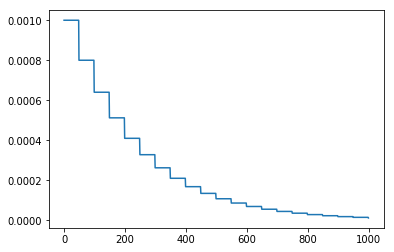

In [20]:
plt.plot(list(map(step_decay, range(1000))))

In [21]:
size_batches=800
ds = PrepareData(X=train_inputs, orientations=train_sin_cos, dimensions=train_dim,
                 positions=train_pos)

ds = DataLoader(ds, batch_size=size_batches, shuffle=True)

train_losses = {'angle loss':[], 'dim loss':[], 'pos loss':[]}
test_losses = {'angle loss':[], 'dim loss':[], 'pos loss':[]}
l1, l2, l3 = [], [], []

In [22]:
print(np.mean(find_losses(test_inputs, test_angles, test_dim, test_pos, net), axis=1))

[178.2541987   91.024838     2.1880381   20.29925249]


### Train

In [23]:
p1, p2, p3 = 1, 12, 0.045

In [24]:
for epoch in range(500):  # loop over the dataset multiple times
    optimizer = optim.Adam(net.parameters(), lr=step_decay(epoch))
    for i, data in enumerate(ds, 0):
        # get the inputs
        batch_inputs, batch_orient, batch_dim, batch_pos = data
        (batch_inputs, batch_orient, batch_dim, batch_pos) = (batch_inputs.to(device), 
                                                                    batch_orient.to(device),
                                                                    batch_dim.to(device),
                                                                    batch_pos.to(device))

        # zero the parameter gradients
        optimizer.zero_grad()
        
        
        # forward + backward + optimize
        batch_outputs = net(batch_inputs)
        out_orient, out_dim, out_pos = batch_outputs[:,:2], batch_outputs[:,2:5], batch_outputs[:,5:8]
        
        l_orient = sin_cos_LossFunc(out_orient, batch_orient)
        l_dim = dim_LossFunc(out_dim, batch_dim)
        l_pos = pos_LossFunc(out_pos, batch_pos)
        
        l1.append(l_orient)
        l2.append(l_dim)
        l3.append(l_pos)
        
        loss = p1*l_orient + p2*l_dim + p3*l_pos
        loss.backward()
        optimizer.step()
    #print(find_loss(train_inputs, train_gts, net))
    
    train_loss = find_losses(train_inputs, train_angles, train_dim, train_pos, net)
    train_losses['angle loss'].append(np.mean(train_loss[1]))
    train_losses['dim loss'].append(np.mean(train_loss[2]))
    train_losses['pos loss'].append(np.mean(train_loss[3]))
    
    test_loss = find_losses(test_inputs, test_angles, test_dim, test_pos, net)
    test_losses['angle loss'].append(np.mean(test_loss[1]))
    test_losses['dim loss'].append(np.mean(test_loss[2]))
    test_losses['pos loss'].append(np.mean(test_loss[3]))
    
    print(epoch,
          '\t train loss',
          round(np.mean(train_loss[1]),2),
          round(np.mean(train_loss[2]),2),
          round(np.mean(train_loss[3]),2),
          '\t test loss',
          round(np.mean(test_loss[1]),2),
          round(np.mean(test_loss[2]),2),
          round(np.mean(test_loss[3]),2))
    
    
print('Finished Training')

0 	 train loss 57.34 0.39 4.76 	 test loss 56.03 0.38 4.64
1 	 train loss 39.46 0.32 3.67 	 test loss 38.76 0.31 3.72
2 	 train loss 33.61 0.29 3.52 	 test loss 33.09 0.28 3.58
3 	 train loss 30.9 0.27 3.35 	 test loss 30.3 0.26 3.43
4 	 train loss 29.69 0.26 3.32 	 test loss 28.88 0.25 3.35
5 	 train loss 28.47 0.25 3.29 	 test loss 27.64 0.24 3.3
6 	 train loss 27.65 0.24 3.3 	 test loss 26.96 0.24 3.24
7 	 train loss 28.25 0.24 3.2 	 test loss 27.35 0.23 3.24
8 	 train loss 27.28 0.24 3.31 	 test loss 26.86 0.23 3.27
9 	 train loss 26.91 0.24 3.23 	 test loss 26.38 0.23 3.22
10 	 train loss 27.02 0.24 3.19 	 test loss 26.75 0.23 3.14
11 	 train loss 26.63 0.23 3.12 	 test loss 26.01 0.23 3.16
12 	 train loss 27.12 0.23 3.1 	 test loss 26.3 0.22 3.19
13 	 train loss 26.5 0.23 3.01 	 test loss 25.86 0.23 3.18
14 	 train loss 26.48 0.23 3.06 	 test loss 25.92 0.22 3.06
15 	 train loss 26.34 0.23 3.08 	 test loss 25.38 0.23 3.12
16 	 train loss 25.73 0.24 3.09 	 test loss 24.73 0.23 3.0

138 	 train loss 22.67 0.21 2.65 	 test loss 23.09 0.22 2.95
139 	 train loss 22.96 0.21 2.63 	 test loss 22.78 0.22 2.96
140 	 train loss 22.66 0.21 2.63 	 test loss 22.72 0.22 3.01
141 	 train loss 22.95 0.21 2.65 	 test loss 23.2 0.22 2.94
142 	 train loss 22.93 0.21 2.64 	 test loss 23.14 0.22 2.95
143 	 train loss 22.75 0.21 2.68 	 test loss 22.97 0.22 2.96
144 	 train loss 23.33 0.21 2.68 	 test loss 23.39 0.22 2.95
145 	 train loss 22.9 0.21 2.64 	 test loss 22.85 0.22 2.95
146 	 train loss 22.66 0.21 2.68 	 test loss 22.77 0.22 2.89
147 	 train loss 22.76 0.21 2.61 	 test loss 22.89 0.22 3.0
148 	 train loss 22.59 0.21 2.64 	 test loss 22.76 0.22 2.97
149 	 train loss 22.42 0.21 2.64 	 test loss 22.61 0.22 2.99
150 	 train loss 22.47 0.21 2.62 	 test loss 22.7 0.22 2.95
151 	 train loss 22.48 0.21 2.65 	 test loss 22.86 0.22 2.9
152 	 train loss 22.37 0.21 2.67 	 test loss 22.5 0.22 2.89
153 	 train loss 22.49 0.21 2.62 	 test loss 22.75 0.22 2.95
154 	 train loss 22.51 0.21 2.

274 	 train loss 21.51 0.2 2.51 	 test loss 22.21 0.22 2.95
275 	 train loss 21.74 0.21 2.51 	 test loss 22.2 0.22 2.95
276 	 train loss 21.56 0.21 2.53 	 test loss 22.3 0.22 2.92
277 	 train loss 21.38 0.2 2.5 	 test loss 21.78 0.22 2.97
278 	 train loss 21.39 0.21 2.51 	 test loss 22.05 0.22 2.94
279 	 train loss 21.29 0.2 2.54 	 test loss 22.05 0.22 2.89
280 	 train loss 21.34 0.2 2.54 	 test loss 22.19 0.22 2.9
281 	 train loss 21.56 0.2 2.52 	 test loss 22.42 0.22 2.92
282 	 train loss 21.43 0.2 2.52 	 test loss 22.16 0.22 2.93
283 	 train loss 21.48 0.2 2.51 	 test loss 22.16 0.22 2.94
284 	 train loss 21.29 0.2 2.54 	 test loss 21.99 0.22 2.89
285 	 train loss 21.47 0.2 2.55 	 test loss 22.14 0.22 2.87
286 	 train loss 21.39 0.2 2.51 	 test loss 22.12 0.22 2.92
287 	 train loss 21.39 0.2 2.54 	 test loss 21.97 0.22 2.91
288 	 train loss 21.42 0.21 2.49 	 test loss 22.08 0.22 2.94
289 	 train loss 21.41 0.21 2.53 	 test loss 22.22 0.22 2.9
290 	 train loss 21.4 0.2 2.53 	 test lo

412 	 train loss 20.73 0.2 2.42 	 test loss 21.58 0.22 2.94
413 	 train loss 20.62 0.2 2.43 	 test loss 21.6 0.22 2.93
414 	 train loss 20.7 0.2 2.44 	 test loss 21.67 0.22 2.88
415 	 train loss 20.68 0.2 2.43 	 test loss 21.72 0.22 2.91
416 	 train loss 20.7 0.2 2.44 	 test loss 21.78 0.22 2.9
417 	 train loss 20.66 0.2 2.44 	 test loss 21.61 0.22 2.89
418 	 train loss 20.75 0.2 2.43 	 test loss 21.83 0.22 2.92
419 	 train loss 20.98 0.2 2.43 	 test loss 22.1 0.22 2.91
420 	 train loss 20.78 0.2 2.44 	 test loss 21.81 0.22 2.88
421 	 train loss 20.65 0.2 2.43 	 test loss 21.85 0.22 2.91
422 	 train loss 20.79 0.2 2.45 	 test loss 21.75 0.22 2.92
423 	 train loss 20.67 0.2 2.42 	 test loss 21.74 0.22 2.92
424 	 train loss 20.67 0.2 2.46 	 test loss 21.82 0.22 2.9
425 	 train loss 20.7 0.2 2.42 	 test loss 21.57 0.22 2.93
426 	 train loss 20.65 0.2 2.44 	 test loss 21.78 0.22 2.88
427 	 train loss 20.75 0.2 2.43 	 test loss 21.77 0.22 2.92
428 	 train loss 20.71 0.2 2.44 	 test loss 21.

In [27]:
for x in gaussian_filter1d(ls1[100:], sigma=200):
    print(x)
print('end')
for x in gaussian_filter1d(ls2[100:], sigma=200):
    print(x)
print('end')
for x in gaussian_filter1d(ls3[100:], sigma=200):
    print(x)


0.37651675449330524
0.3765156433201023
0.3765134057812701
0.3765099778753003
0.3765054982799154
0.3764999052097313
0.37649318435752577
0.3764853229953186
0.37647633056898056
0.37646622450231093
0.3764550052591292
0.3764426392776568
0.3764291715184577
0.3764145682057434
0.3763988462358617
0.37638199688036666
0.3763640338933281
0.376344964142949
0.3763247801648898
0.37630346854770724
0.3762810242447782
0.3762574821168823
0.3762328299665715
0.3762070617834987
0.3761802051629304
0.3761522102291701
0.3761231012766443
0.37609289314151334
0.3760615792709958
0.3760291705929421
0.3759956678028738
0.37596104423604804
0.37592534589147153
0.3758885386570285
0.3758506429323115
0.3758116608415664
0.37577155374174553
0.37573038398041686
0.37568812206861035
0.37564478088776176
0.37560035137822284
0.3755548443985763
0.375508267178794
0.37546060357606337
0.37541186496449697
0.3753620634311702
0.3753111840967917
0.37525925398395976
0.37520624974273686
0.3751521811319835
0.375097039790271
0.37504085058347

0.25033076728665116
0.2503230624328786
0.2503153687624477
0.25030767450960906
0.2502999687181706
0.25029229437240186
0.25028456488082035
0.2502768873986619
0.2502691924040456
0.25026148536889736
0.25025378916557184
0.25024608890678957
0.2502384070480275
0.2502307079364461
0.250223012464795
0.2502153155119269
0.25020763256584005
0.250199935317353
0.25019224264531836
0.25018456387421456
0.25017689288651
0.25016921566610695
0.25016153886845816
0.2501538564723432
0.2501461738709093
0.2501384817232102
0.2501308019919166
0.2501231164000413
0.2501154505080559
0.25010777757934294
0.25010011242492214
0.25009242920819225
0.2500847669701747
0.250077096687875
0.25006943437946844
0.2500617655910934
0.25005409632728204
0.25004642646629965
0.2500387629346861
0.25003110060011424
0.2500234483000953
0.25001579053381956
0.2500081258908345
0.2500004739810026
0.24999282593844385
0.2499851969435063
0.24997755707360958
0.24996991518412914
0.2499622524654227
0.24995463331441448
0.24994701216092838
0.249939390

0.2368972940601176
0.23689074121137893
0.23688420125092138
0.23687769260070463
0.23687118569388252
0.2368646977243782
0.23685822677675356
0.23685177508850125
0.23684535275326976
0.23683893620392513
0.23683254416022684
0.23682615622011763
0.2368197806946117
0.23681343677813585
0.23680710490212484
0.23680078933181226
0.23679447938703604
0.23678818702735835
0.23678191004288512
0.23677565382777932
0.23676940328863794
0.23676318481323902
0.2367569716726009
0.23675077000167855
0.2367446192376903
0.23673844466029106
0.2367323154856085
0.23672618165549122
0.23672007964565547
0.23671398845415162
0.23670790341942968
0.2367018327636891
0.2366957769820533
0.23668975730970873
0.23668373669960416
0.2366777289368434
0.23667174365150118
0.23666578290966908
0.23665982778672787
0.2366538835549564
0.23664797226098735
0.23664208463474415
0.2366361913869067
0.23663031822214586
0.23662446650741847
0.23661861502822676
0.23661278449396667
0.23660695502097642
0.23660116782619406
0.23659540129319093
0.236589638

0.22716764105231738
0.22716692939963623
0.227166218872537
0.22716550873027938
0.2271648050720577
0.2271641075445428
0.22716340514281463
0.22716271325819726
0.2271620135240578
0.22716130616198368
0.22716061079470468
0.22715990804066785
0.22715921751416174
0.22715853823579418
0.22715785159358165
0.2271571792804868
0.2271565142995343
0.22715584224774235
0.22715517756611145
0.22715450175819024
0.22715384152262794
0.22715316161870105
0.227152502891903
0.22715184149262357
0.2271511845806345
0.22715053935364102
0.22714989207058203
0.22714925661352092
0.2271486141209014
0.2271479697448056
0.22714733064486875
0.2271467106024055
0.2271460877123464
0.22714546948362613
0.22714483761395157
0.22714422041280874
0.22714360308562132
0.22714300371699198
0.2271423957003467
0.22714179604753174
0.22714118714985143
0.22714057191645012
0.22713997687541043
0.2271393835305166
0.22713879383853558
0.22713820420525674
0.22713761447723912
0.22713702322010015
0.22713643736459696
0.22713587280569217
0.22713528559036

0.22117312202222533
0.22117432724003674
0.22117551469087052
0.22117671042377338
0.22117788572567657
0.22117906196038897
0.22118023749690519
0.22118145024368968
0.22118263591439555
0.22118382897085212
0.22118500647824238
0.2211861931191087
0.22118737458741808
0.22118854461111387
0.22118972244385662
0.22119089007600876
0.22119205847550338
0.22119323656470932
0.22119439368975996
0.22119556497683984
0.22119672282056135
0.22119789065240836
0.22119903587472184
0.2212001917327373
0.22120134941925507
0.22120249327763564
0.2212036379358766
0.22120478577635586
0.2212059270422211
0.2212070714609119
0.22120821066855137
0.2212093521499052
0.22121048087223166
0.22121159614139502
0.22121272821841204
0.22121383595768004
0.22121494494672575
0.22121606466892046
0.22121717706901037
0.22121827169190297
0.2212193750980504
0.2212204779559924
0.22122156249942634
0.2212226347992745
0.2212237196750349
0.22122481676725286
0.22122588704949683
0.2212269703543547
0.2212280456497681
0.22122911862183356
0.2212301793

0.21629017891611763
0.21628814209221742
0.21628612280575496
0.2162840776152506
0.2162820553334017
0.21628004580350504
0.21627804107841095
0.21627604020297544
0.21627404907531886
0.21627205397192112
0.2162700624251087
0.216268082846559
0.2162660891300877
0.21626410593524448
0.21626213961526003
0.21626016487309388
0.2162581913042499
0.2162562223797642
0.21625426412344442
0.21625231075530368
0.21625035875493084
0.21624841552952448
0.21624646557212246
0.21624452397712648
0.21624260235328002
0.21624065368451412
0.2162387289222951
0.2162368010196061
0.21623490039063503
0.21623299882006988
0.21623109710691102
0.21622918616123557
0.21622726973046727
0.21622537383647103
0.21622348353468065
0.216221616143224
0.21621974705116573
0.21621788029765582
0.21621601086220457
0.21621414561280783
0.21621228848915267
0.21621042310240127
0.21620858468154758
0.2162067300129711
0.21620488940804414
0.2162030470536119
0.2162012133260737
0.21619939111638983
0.21619756212805832
0.21619573842076711
0.2161939093105

0.2114826848266423
0.21148095065043493
0.2114792265681206
0.211477490761382
0.21147577304712104
0.2114740544452981
0.2114723594340262
0.2114706707461976
0.21146900619196138
0.2114673575726882
0.21146570035830065
0.2114640559732323
0.21146241893649795
0.21146078498048745
0.21145916258081396
0.21145755943722477
0.21145595259710476
0.21145436808367235
0.21145278171750445
0.21145121176129253
0.21144964707846858
0.21144808607124535
0.2114465405601988
0.2114449910612531
0.21144346913048936
0.21144194347975442
0.21144042439575436
0.21143891248483979
0.21143742021058146
0.2114359424295032
0.21143446948901062
0.2114330059629546
0.2114315592117185
0.21143011305214085
0.21142867885032599
0.2114272625952826
0.2114258477024553
0.21142444013179085
0.2114230409966042
0.21142164858826443
0.21142027223408133
0.21141890451252315
0.21141754350436234
0.21141618513134727
0.211414836436241
0.2114134834862756
0.21141216901487384
0.21141085279409375
0.21140954534970247
0.21140823745421847
0.21140694609648458


0.20859436988569674
0.20859470302690145
0.20859501293520902
0.20859533589293408
0.20859565641913722
0.20859599802534967
0.20859633738541883
0.208596681702332
0.2085970388693234
0.20859739054489587
0.20859775102377023
0.2085981282122211
0.20859850643079242
0.2085988851726106
0.20859926554206368
0.20859964944140386
0.2086000381573204
0.20860042511145696
0.208600813694575
0.2086012029450257
0.20860160321679283
0.20860199035295135
0.2086024039440504
0.20860281776970688
0.20860323313285448
0.20860367989803988
0.20860410023790688
0.2086045270929728
0.20860495969697063
0.20860540037817446
0.2086058571489681
0.20860630861524704
0.20860676273428783
0.20860721147110783
0.20860767188522358
0.20860813914574344
0.20860860704206252
0.20860907175509247
0.20860955140743498
0.20861002835232983
0.20861051234645356
0.20861099467475086
0.20861147225512633
0.2086119617816972
0.2086124567808073
0.20861295737999336
0.20861346758133106
0.2086139787855811
0.20861448660110263
0.20861499077519147
0.2086155186203

0.20671947042591518
0.20671879747518615
0.20671812341093934
0.20671742788560454
0.20671673623999667
0.20671604689034104
0.2067153395059029
0.2067146361428849
0.20671391214308638
0.2067131932283769
0.20671246041145583
0.20671171518951034
0.20671097345924735
0.2067102318428251
0.206709472594658
0.2067087105592051
0.2067079434674861
0.20670719322404862
0.20670642054609029
0.20670563597429767
0.2067048475640537
0.20670404734002307
0.2067032627447754
0.2067024656462362
0.20670165270649857
0.2067008426440918
0.2067000112959678
0.20669918613632005
0.20669836338182546
0.2066975307291079
0.2066966999698587
0.2066958564220646
0.2066949996697386
0.20669415210947628
0.20669329203715311
0.20669242664208798
0.20669155395335315
0.20669068498337465
0.20668981407467168
0.2066889232879887
0.2066880398418946
0.20668716162756767
0.2066862517613137
0.20668534491166454
0.2066844330693564
0.2066835203418938
0.20668261049566702
0.20668169411508697
0.20668077667241747
0.2066798554902421
0.20667890659863228
0.2

0.26800429430289474
0.26799250803999225
0.26798067556235816
0.2679688208082344
0.26795691309765224
0.2679449994421639
0.2679330331577883
0.26792103902158354
0.26790898966826715
0.2678969356303819
0.2678848518238268
0.26787271954559244
0.2678605561143489
0.26784834965872595
0.2678361215189457
0.26782384222787947
0.2678115481276682
0.2677991801761294
0.2677867879997739
0.2677743539565148
0.2677618965170488
0.267749397379718
0.2677368622086243
0.2677242911337523
0.267711683810257
0.2676990878235538
0.2676862177540091
0.26767351717983495
0.26766070882997445
0.2676478221089383
0.2676349463020064
0.2676220675805943
0.26760915849827877
0.2675961726840745
0.26758314569028696
0.26757009620331734
0.2675570125179944
0.26754389469887696
0.26753076899008016
0.26751758172534007
0.2675043219447112
0.2674910482509229
0.267477725630778
0.2674643541255899
0.2674509514318491
0.26743749967832675
0.2674239952154012
0.2674104664803794
0.2673968937378354
0.26738328966710384
0.26736963055541685
0.267355938083

0.23666677792545782
0.2366631715276598
0.23665956520413797
0.2366559846139969
0.23665240176331712
0.23664886113214817
0.2366452914696859
0.23664173791404222
0.2366382010131594
0.23663467263584428
0.23663117262293643
0.23662766495343351
0.23662417346958795
0.2366206764008902
0.23661719008225993
0.23661373605324118
0.23661028286943053
0.23660685423364725
0.23660343597637462
0.23660003229674692
0.23659661623928974
0.2365932142632853
0.23658982464353648
0.23658645206878454
0.23658309410745368
0.2365797276127801
0.2365763766929159
0.23657303849212138
0.23656971430745574
0.23656639226443146
0.23656308930457168
0.23655979633424512
0.23655651978966805
0.2365532689184525
0.23655001225182543
0.23654678308720456
0.23654356025340967
0.23654035563493345
0.23653713099269755
0.23653393311161017
0.23653075555231795
0.23652758124390258
0.2365244258617652
0.23652127715734578
0.2365181382720359
0.2365150131607763
0.23651188832451733
0.2365088060248251
0.2365057240142506
0.2365026318933601
0.2364995702654

0.22772052714598004
0.22771824096723178
0.2277159279034027
0.22771362555758254
0.2277112928896541
0.22770896159299667
0.22770662498145325
0.22770427994409717
0.22770193974970893
0.22769958720125275
0.2276972159561509
0.22769485067923637
0.22769247410198934
0.2276900875725074
0.22768770331361524
0.22768532474536748
0.22768294268427247
0.22768054295874285
0.22767815063478833
0.22767575460664677
0.22767334989743448
0.22767093573860445
0.22766850668359936
0.22766608410088193
0.22766364403126627
0.227661211465813
0.22765878293126654
0.22765633928511025
0.22765387907060816
0.2276514127786998
0.22764894896465354
0.22764648581580363
0.22764402852748897
0.2276415517083099
0.22763907087806468
0.22763659498140312
0.22763412018437298
0.22763161409809268
0.22762914307034374
0.22762663129182759
0.2276241365528403
0.22762164794984785
0.22761914532448033
0.22761661868802258
0.22761410350270828
0.2276115790256213
0.2276090477229901
0.2276065192248631
0.22760396832351432
0.2276014342539136
0.22759889251

0.2199297982492431
0.21992652723635442
0.21992324894820292
0.21991996456405188
0.21991667418933344
0.2199133660265071
0.21991005082235188
0.21990672306947925
0.21990340068001743
0.21990005744200805
0.2198966901663943
0.2198933159943123
0.21988993842931265
0.21988655028293044
0.21988315041510004
0.21987974867144155
0.21987634821178417
0.2198729277863025
0.2198694960522099
0.21986605753727004
0.21986259802687844
0.21985913304306998
0.21985565997848722
0.21985219307490547
0.21984870564811335
0.2198452180822953
0.21984171590202517
0.2198381954634887
0.21983466957340128
0.2198311411364091
0.21982760808569873
0.21982405524615814
0.21982050796991187
0.21981694585405742
0.21981334787922338
0.2198097626244636
0.21980616955724205
0.21980256405133927
0.219798945293575
0.21979533590743067
0.21979170176611304
0.219788058045486
0.21978440555909454
0.21978074269458195
0.21977708510412297
0.21977341890533625
0.2197697345077311
0.21976604115873882
0.219762334102436
0.21975862455149284
0.219754915478357

0.21386869248746565
0.21386780088911259
0.2138669146153031
0.21386602776321287
0.2138651250130543
0.2138642146749014
0.2138632923938758
0.2138623509576875
0.21386141295225397
0.21386045772814116
0.213859495458187
0.2138585289241685
0.21385757911673034
0.21385660041838184
0.2138556247478892
0.21385464183790528
0.21385363623675221
0.2138526127803489
0.2138515942057925
0.21385055801570846
0.2138495368285392
0.21384849345327175
0.2138474584321937
0.21384640512195724
0.21384534265015898
0.21384427490276564
0.2138431985224436
0.21384212153682794
0.21384102597557997
0.21383994124670228
0.21383882419438516
0.21383771442185395
0.21383658069991016
0.21383544413512456
0.2138343070889456
0.21383317394930676
0.21383203516262558
0.21383086601291115
0.21382968968432445
0.21382849762653652
0.21382733167582887
0.21382613828855598
0.21382494253093348
0.21382373100086163
0.21382249855517838
0.21382127377392854
0.21382005845328372
0.213818820925488
0.21381757325527062
0.2138163130743925
0.2138150511867069

0.20970668499302508
0.20970570881369563
0.20970474219220933
0.20970377204125223
0.2097027953107033
0.20970180248011494
0.2097008191431536
0.2096998263501554
0.20969883321511842
0.20969782720654376
0.2096968109033315
0.20969580328856713
0.20969478160906066
0.20969375351693562
0.209692734695744
0.20969170007590504
0.209690654159306
0.20968961896963273
0.20968858429417153
0.2096875386752042
0.20968647204238877
0.20968540896431334
0.20968435392892
0.20968329269301425
0.20968221948616392
0.20968114941224777
0.20968007220235566
0.20967901683187204
0.20967792950088837
0.2096768403375915
0.2096757560109341
0.2096746726157574
0.20967356952583202
0.2096724446121116
0.20967132483035436
0.20967022027725904
0.20966909618199178
0.2096679812732513
0.20966684029274188
0.20966568576108285
0.20966455646490523
0.2096634319635636
0.2096622958835722
0.20966115992776804
0.20966000978963875
0.2096588598867667
0.2096577033799354
0.2096565340615224
0.20965538344754106
0.20965422793767277
0.20965306697634598
0.

0.20631277230667713
0.2063126323759553
0.20631249282772382
0.2063123405767493
0.20631219684736524
0.20631207892993433
0.20631193948716023
0.2063118029186484
0.2063116665971646
0.20631152781319737
0.20631139002140783
0.2063112590519411
0.2063111258821284
0.2063110043765483
0.2063108712832134
0.2063107289838044
0.20631059982514605
0.2063104781782395
0.20631036388647014
0.20631023825053885
0.20631012002805077
0.20631001028530563
0.20630987928901928
0.20630976436482684
0.20630964395011162
0.20630952625362342
0.2063093902384214
0.20630925879076026
0.20630915551728335
0.20630904621708313
0.2063089348093435
0.20630881227175948
0.2063086952261761
0.20630857427820964
0.20630845070249063
0.20630833850604427
0.20630823086491112
0.20630812291541709
0.20630802471210136
0.20630790553379943
0.20630779274959732
0.20630769082987893
0.2063075778443606
0.20630747537090205
0.2063073689375459
0.20630726665994517
0.20630715689258472
0.20630705651520254
0.20630694967185406
0.206306841500919
0.206306745950550

0.38151553823800644
0.3815144757895896
0.3815123372948658
0.381509134231111
0.38150490626133005
0.38149961348761235
0.3814932638173957
0.3814858484202981
0.38147736917881303
0.38146784103868725
0.38145721787429515
0.38144557965658915
0.3814328880118825
0.38141915210422095
0.3814043506423273
0.3813885146516841
0.38137164186434835
0.3813536883788324
0.3813346758334604
0.3813146011023401
0.3812934948291199
0.38127132677488407
0.3812481336381153
0.38122389881954344
0.3811985779835665
0.38117222641985843
0.38114480567896464
0.38111634637425745
0.38108686377653433
0.38105633449185583
0.38102480687060436
0.3809922177934885
0.38095862448822826
0.38092394339071606
0.3808883026767618
0.38085161544479984
0.3808138419164962
0.38077509412869553
0.38073530764975033
0.3806945027867084
0.38065270219519504
0.3806098362722082
0.3805659902879901
0.3805211237515408
0.38047524887271816
0.38042834224640976
0.3803804857778621
0.38033159842229985
0.38028170908091197
0.380230814907694
0.38017894715421185
0.380

0.24112434388185539
0.24112107882313638
0.24111778733826292
0.2411144789995406
0.24111118272325577
0.24110790298195167
0.2411046035841057
0.2411013293856857
0.24109803203097277
0.24109473314028546
0.24109146098982473
0.24108818636639479
0.24108488728429597
0.24108158394581158
0.24107827734002768
0.24107495953385613
0.24107164111958496
0.24106835295723694
0.24106502381525927
0.24106171279184344
0.2410584341370704
0.24105514176833728
0.24105184952194986
0.2410485396686025
0.2410452259703004
0.24104193292655798
0.2410386606309027
0.24103534636086643
0.2410320380283513
0.24102871632637246
0.24102540766071046
0.2410221075773214
0.24101880899786185
0.2410155050634083
0.241012180423659
0.24100885628713817
0.24100553628381663
0.24100220806788772
0.2409988733288598
0.24099555117381677
0.24099224006908715
0.24098891126881067
0.2409855976406139
0.24098228530271076
0.2409789488224892
0.24097563439943873
0.24097227150478925
0.2409689287266436
0.24096561124333718
0.24096224348568931
0.24095889621885

0.22312799877520223
0.22312556616491006
0.22312315788652423
0.22312075954261285
0.2231183588332615
0.22311602010374543
0.22311365340834657
0.2231113342971672
0.22310901911983236
0.22310672845479024
0.2231044820359742
0.22310223676570284
0.22309999820307877
0.22309782551122065
0.22309564151015043
0.2230934624501289
0.22309130829187135
0.2230891733944799
0.2230870655731239
0.22308499529211434
0.22308296515857984
0.22308089635495387
0.22307887400984677
0.22307687463915335
0.2230748658828612
0.22307285743069907
0.2230708614423485
0.22306891771969822
0.22306700687771422
0.22306509729425994
0.22306319297855073
0.22306130649541425
0.2230594485655489
0.22305756181654224
0.22305573189767183
0.2230539144472874
0.22305208127101386
0.2230503113311993
0.2230485234563506
0.2230467452651678
0.22304493054909963
0.22304315562352187
0.22304144310768487
0.2230397172643092
0.223038002438184
0.22303631181952427
0.2230346189652815
0.22303293212331546
0.22303129696615262
0.2230296720841805
0.2230280249344912

0.21352915943964315
0.2135266393446471
0.2135241644913269
0.21352165215425253
0.213519158671263
0.2135166227871929
0.2135140839758935
0.21351160251860607
0.21350909330447268
0.21350659469845823
0.21350410268526257
0.2135016292776846
0.21349915334557823
0.2134966585985009
0.21349415484481943
0.213491664531096
0.21348918697866198
0.21348672135131574
0.21348422071102016
0.21348173774489015
0.21347923107136682
0.21347675722334633
0.21347430975137094
0.21347183568691544
0.21346930976768055
0.21346685863126158
0.21346438735364384
0.21346189753122688
0.2134594074236347
0.2134569701593305
0.21345453073812998
0.21345206243317916
0.21344960070038715
0.21344715674951348
0.21344472185711572
0.21344224267558434
0.2134397955777603
0.21343732684953853
0.2134348869690832
0.21343246049591194
0.21342999416403563
0.21342755781592354
0.21342512385572732
0.21342267842364693
0.21342022885813203
0.2134178064947545
0.2134153634337246
0.21341293495870808
0.2134105207651493
0.21340809658268495
0.213405655955111

0.20611091503064524
0.2061111639421546
0.206111390778136
0.20611166634432695
0.20611190644917066
0.2061121910491524
0.2061124612649658
0.20611268448977604
0.20611293280361057
0.20611318524487615
0.20611344316963756
0.2061136773768342
0.20611391691089043
0.2061141373620806
0.20611440906366632
0.20611465055653738
0.20611487447703797
0.20611512419928585
0.20611537932239754
0.2061156057784188
0.20611584650414352
0.20611606591988244
0.20611627082933026
0.20611649237751706
0.20611669245557115
0.20611687503237563
0.20611709266843908
0.2061172802156315
0.2061174701120212
0.20611768131464941
0.20611787456223624
0.20611804990791824
0.20611820888376642
0.20611837515815618
0.20611854897621915
0.20611871999543377
0.20611888685690696
0.20611905530192257
0.2061191636509336
0.20611928331687887
0.2061194046318847
0.20611951712263238
0.20611964583230885
0.206119747521276
0.20611985209642542
0.20611996607855745
0.20612005604998407
0.206120155746441
0.2061202102984578
0.20612025285702396
0.206120308599773

0.19883292555473195
0.1988337927295521
0.198834661066435
0.19883553378060081
0.19883639209642176
0.19883724188349983
0.1988380922329747
0.19883891425655906
0.1988397530755056
0.19884059995034736
0.19884146873626793
0.1988423030251397
0.19884314005289913
0.19884398213116244
0.19884481811818447
0.19884564192032236
0.19884647998118465
0.19884733224764783
0.19884812787097964
0.1988489578813251
0.1988497898296006
0.1988506135384452
0.198851413867087
0.19885221374371356
0.1988530282105251
0.1988538579241195
0.19885467789698746
0.19885549385516735
0.19885632442774404
0.19885712653611606
0.19885793314607786
0.1988587393193293
0.198859537965364
0.19886035840054017
0.19886113656198862
0.1988619175845223
0.19886268801042817
0.19886347932953133
0.19886424678315268
0.19886500313002167
0.19886574603405568
0.19886650825101967
0.19886720999643742
0.1988679284354819
0.19886864983632735
0.19886937877769692
0.19887012051564792
0.1988708467648666
0.19887155749665117
0.19887226994335117
0.19887297502272483

0.194270490730786
0.19427045512841715
0.1942703887963063
0.19427029796689596
0.19427020599488126
0.19427009603455944
0.1942699922598907
0.19426987287655761
0.19426975987287345
0.19426962704217177
0.19426950121027267
0.19426935921815405
0.19426923437425897
0.19426908028586948
0.1942689124519417
0.1942687262355967
0.19426854794995532
0.19426834344686753
0.19426815105723072
0.19426792613091448
0.1942676630058386
0.19426744130624898
0.19426720224927302
0.194266934354581
0.19426667807270218
0.19426636232605698
0.19426606366807941
0.1942657889507498
0.1942654901239969
0.19426517360098297
0.19426484306036726
0.19426450986193936
0.19426416309992967
0.1942638334065969
0.19426343956896597
0.19426304558556332
0.19426263983805675
0.19426227243957345
0.1942618754955589
0.19426145440579876
0.194261026346297
0.1942605893384644
0.19426014199738348
0.19425968451059547
0.19425921228306903
0.19425873503934346
0.1942582718771798
0.19425777619579007
0.19425725527185086
0.19425673104043464
0.194256183614915

In [ ]:
print(gaussian_filter1d([1.0*x for x in train_losses['dim loss']], sigma=3))
print(gaussian_filter1d([1.0*x for x in test_losses['dim loss']], sigma=3))


In [ ]:
print(gaussian_filter1d([1.0*x for x in train_losses['pos loss']], sigma=3))
print(gaussian_filter1d([1.0*x for x in test_losses['pos loss']], sigma=3))


#### Loss plot

In [26]:
from scipy.ndimage.filters import gaussian_filter1d

In [25]:
ls1=[p1*x.cpu().detach().numpy() for x in l1]
ls2=[p2*x.cpu().detach().numpy() for x in l2]
ls3=[p3*x.cpu().detach().numpy() for x in l3]

#plt.plot(gaussian_filter1d(ls1[100:], sigma=200))
#plt.plot(gaussian_filter1d(ls2[100:], sigma=200))
#plt.plot(gaussian_filter1d(ls3[100:], sigma=300))


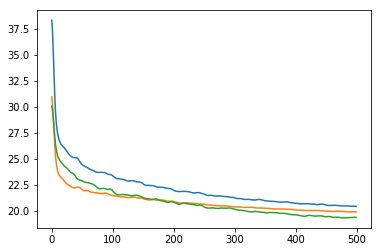

In [38]:
plt.plot(gaussian_filter1d([1.0*x for x in train_losses['angle loss']], sigma=3))
plt.plot(gaussian_filter1d([100*x for x in train_losses['dim loss']], sigma=3))
plt.plot(gaussian_filter1d([8*x for x in train_losses['pos loss']], sigma=3))

#### save model

In [34]:
name = 'net-multi-final.pkl'
torch.save(net.state_dict(), name)

In [35]:
name = '../kitti-ml-loc/net-nuscunes-multi-final.pkl'
torch.save(net.state_dict(), name)

#### load model

In [16]:
params = torch.load('net-multi-final.pkl')
net.load_state_dict(params)

### Evaluate and visualize

#### append results to test data

In [21]:
out_sample = infer(test_inputs, net)
for i, data in enumerate(test_data):
    data['pred_orient'] = out_sample[0][i]
    data['pred_dim'] = out_sample[1][i]
    data['pred_pos'] = out_sample[2][i]

#### results of one pedestrian

In [22]:
i = 7898

print(np.round(test_angles[i],2), np.round(test_dim[i],2), np.round(test_pos[i],2))
print(np.round(out_sample[0][i],2), np.round(out_sample[1][i],2), np.round(out_sample[2][i],2))

76.33 [0.43 0.72 2.  ] [10.95  0.47 42.28]
90.52 [0.73 0.83 1.86] [10.31  0.44 40.33]


#### error distribution for orientation and dim

In [23]:
all_errors = find_losses(test_inputs, test_angles, test_dim, test_pos, net)
errors_angles = all_errors[1]
errors_dim = all_errors[2]
errors_pos = all_errors[3]

In [24]:
print('angles:', np.mean(errors_angles), np.median(errors_angles))
print('dim:', np.mean(errors_dim), np.median(errors_dim))
print('pos:', np.mean(errors_pos), np.median(errors_pos))


angles: 21.484285143062714 12.14485314658016
dim: 0.21621545538503173 0.20051967784836539
pos: 2.904784763437724 1.6366179341996796


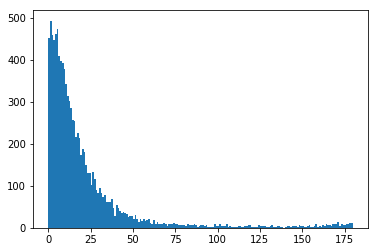

In [25]:
fig, ax = plt.subplots()

ax.hist(np.array(errors_angles),bins=180)

plt.show()

#### success classification rate

In [26]:
(1-np.sum(abs(np.floor(out_sample[0]/45).astype(int)-np.floor(test_angles/45).astype(int))>0)/len(test_angles))*100

63.06208796615172

### evaluate naive 2d pos

In [40]:
def pixel_to_camera(uv1, kk, z_met):
    """
    (3,) array --> (3,) array
    Convert a point in pixel coordinate to absolute camera coordinates
    """

    kk_1 = np.linalg.inv(kk)
    xyz_met_norm = np.dot(kk_1, uv1)
    xyz_met = xyz_met_norm * z_met
    return xyz_met

In [41]:
for data in test_data:
    data['naive_pos'] = pixel_to_camera(np.array([(data['pp_box'][2]+data['pp_box'][0])/2,
                                                  (data['pp_box'][3]+data['pp_box'][1])/2, 1]),
                                        data['cam intrinsic'], data['pred_pos'][2])
    
    

In [42]:
pred_pos_errors = []
naive_pos_errors = []

for data in test_data:
    pred_pos_errors.append(abs(data['position'] - data['pred_pos']))
    naive_pos_errors.append(abs(data['position'] - data['naive_pos']))

In [43]:
print(np.mean(pred_pos_errors, axis=0))
print(np.mean(naive_pos_errors, axis=0))

[0.6277646  0.26048858 2.67457396]
[0.85794349 0.11380537 2.67457396]


In [44]:
pred_pos_errors = []
naive_pos_errors = []

for data in test_data:
    pred_pos_errors.append(np.linalg.norm(data['position'][:2] - data['pred_pos'][:2]))
    naive_pos_errors.append(np.linalg.norm(data['position'][:2] - data['naive_pos'][:2]))
print(np.mean(pred_pos_errors, axis=0))
print(np.mean(naive_pos_errors, axis=0))

0.7281467664007757
0.8795743190083029


### work with DF

In [45]:
import pandas as pd
test_df = pd.DataFrame(test_data)

#### add errors to df

In [46]:
##  add orientation error
angle_loss = abs(test_df['orientation']-test_df['pred_orient'])
angle_loss = np.array(list(map(lambda x: x if x < 180 else 360-x, angle_loss)))
test_df['error_orient'] = angle_loss

## add dim error
pred_dim = np.array(test_df['pred_dim'].tolist())
og_dim = np.array(test_df['dimensions'].tolist())

dim_loss = np.linalg.norm(pred_dim - og_dim, axis=1)
test_df['error_dim'] = dim_loss

## add pred pos error
pred_pos = np.array(test_df['pred_pos'].tolist())
og_pos = np.array(test_df['position'].tolist())

pos_loss = np.linalg.norm(pred_pos - og_pos, axis=1)
test_df['error_pos'] = pos_loss

## add naive pos error
#pred_pos = np.array(test_df['naive_pos'].tolist())
#og_pos = np.array(test_df['position'].tolist())

#pos_loss = np.linalg.norm(pred_pos - og_pos, axis=1)
#test_df['error_npos'] = pos_loss

## add xyz error
test_df['error_x'] = abs(pred_pos[:,0] - og_pos[:,0])
test_df['error_y'] = abs(pred_pos[:,1] - og_pos[:,1])
test_df['error_z'] = abs(pred_pos[:,2] - og_pos[:,2])

test_df['error_w'] = abs(pred_dim[:,0] - og_dim[:,0])
test_df['error_d'] = abs(pred_dim[:,1] - og_dim[:,1])
test_df['error_h'] = abs(pred_dim[:,2] - og_dim[:,2])


test_df.describe()

distance   orientation   pred_orient  error_orient     error_dim  \
count  10163.000000  10163.000000  10163.000000  10163.000000  10163.000000   
mean      19.353631    186.608328    187.509542     21.489437      0.217181   
std       10.420772    104.446760    106.067971     29.717071      0.110026   
min        2.077119      0.004663      0.087280      0.002049      0.010894   
25%       11.474087    105.027674    105.203134      5.433862      0.138237   
50%       17.287049    182.293112    184.729121     12.235160      0.201191   
75%       25.423275    276.958545    278.553912     24.110506      0.281208   
max       64.869407    359.972128    359.990495    179.951775      1.088860   

          error_pos       error_x       error_y       error_z       error_w  \
count  10163.000000  10163.000000  10163.000000  10163.000000  10163.000000   
mean       2.890793      0.627765      0.260489      2.674574      0.088770   
std        3.152833      0.643584      0.218366      3.196864      0.073600   
min        0.057433      0.000298      0.000024      0.000034      0.000023   
25%        0.864926      0.207225      0.099664      0.585840      0.033218   
50%        1.663085      0.457351      0.209230      1.439974      0.071708   
75%        3.618864      0.838398      0.364194      3.446853      0.127140   
max       25.824388     10.158398      4.819800     25.772307      0.889833   

            error_d       error_h  
count  1.016300e+04  10163.000000  
mean   1.293013e-01      0.107958  
std    9.863926e-02      0.088735  
min    9.536743e-08      0.000003  
25%    5.180922e-02      0.041419  
50%    1.093312e-01      0.088858  
75%    1.847860e-01      0.150657  
max    7.552594e-01      0.899865

#### filter df

In [156]:
filter_df = test_df
#filter_df = test_df[test_df['filepath']==test_data[7]['filepath']]

#filter_df = test_df[test_df['error_orient']<2]
filter_df = filter_df[filter_df['distance']<5]
#filter_df = filter_df[filter_df['orientation']>330]
len(filter_df.index)

258

In [230]:
filter_df.index[234]

9263

In [93]:
(1-np.sum(abs(np.floor(np.array(filter_df['pred_orient'].tolist())/45).astype(int)-np.floor(np.array(filter_df['orientation'].tolist())/45).astype(int))>0)/len(np.array(filter_df['pred_orient'].tolist())))*100





100.0

In [141]:
print(len(filter_df)*100/len(test_df))
len(filter_df.index)

0.01967922857423989


2

#### Visualize one pedestrian

In [147]:
i= 7
pedestrian=test_data[i]


In [148]:
print(np.round(pedestrian['orientation'],2), np.round(pedestrian['position'],2), np.round(pedestrian['dimensions'],2))
#print(np.round(pedestrian['pred_orient'],2), np.round(pedestrian['naive_pos'],2), np.round(pedestrian['pred_dim'],2))
print(np.round(pedestrian['pred_orient'],2), np.round(pedestrian['pred_pos'],2), np.round(pedestrian['pred_dim'],2))


300.99 [-0.87  0.87 15.63] [0.43 0.57 1.72]
306.22 [-1.    0.71 17.16] [0.77 0.9  1.87]


In [149]:
def project_to_pixels(xyz, kk):
    """Project a single point in space into the image"""
    xx, yy, zz = np.dot(kk, xyz)
    uu = int(xx / zz)
    vv = int(yy / zz)

    return uu, vv

In [228]:
def show_3d(pedestrian):
    
    pedestrian = cp.deepcopy(pedestrian)

    im = np.array(Image.open(pedestrian['filepath']), dtype=np.uint8)

    scale_r = 0.09

    # Create figure and axes
    fig,ax = plt.subplots(1, 2,figsize=(15,5))

    # Display the image

    box = pedestrian['pp_box']

    box = list(map(lambda x: 0 if x<0 else x, box))
    
    shift = np.array([int((1-scale_r)*box[0]),int((1-scale_r)*box[1])])

    ax[0].imshow(im[int((1-scale_r)*box[1]):int((1+scale_r)*box[3]),int((1-scale_r)*box[0]):int((1+scale_r)*box[2])])
    ax[1].imshow(im)

    #show keypoints

    centered_kp=pedestrian['og_keypoints']-shift

    ax[0].scatter(centered_kp[:,0],centered_kp[:,1],c='r')

    #get 3d pred box corners
    def rotate_point(angle, vect):
        angle = angle*math.pi/180
        rot_matrix = np.array([[math.cos(angle), 0, -math.sin(angle)],
                               [0, 1, 0],
                               [math.sin(angle), 0, math.cos(angle)]])
        return np.dot(rot_matrix, vect)
    
    fix_angle = math.atan2(pedestrian['pred_pos'][0] , pedestrian['pred_pos'][2])*180/math.pi
    
    fix_angle =0
    
    def get_corner(w, h, d):
        return np.array(list(project_to_pixels(center+rotate_point(-pedestrian['pred_orient']+fix_angle ,np.array([w,h,d])),
                                               pedestrian['cam intrinsic'])))-shift
    corners = []

    width = pedestrian['pred_dim'][0]
    depth = pedestrian['pred_dim'][1]
    height = pedestrian['pred_dim'][2]
    center = pedestrian['naive_pos']
    
    signs = [(-1,-1,-1), (-1,-1,+1), (+1,-1,+1), (+1,-1,-1), (-1,+1,-1), (-1,+1,+1), (+1,+1,+1), (+1,+1,-1)]

    for i,j,k in signs:
        corners.append(get_corner(i*width/2, j*height/2, k*depth/2))
    
    #connect all corners
    
    connections = [(0,1), (1,2), (2,3), (3,0), (4,5), (5,6), (6,7), (7,4), (0,4), (1,5), (2,6), (3,7)]

    for i, j in connections:
        ax[0].plot([corners[i][0],corners[j][0]] , [corners[i][1],corners[j][1]], c = 'b')
        if (i,j) == (5,6):
            ax[0].plot([corners[i][0],corners[j][0]] , [corners[i][1],corners[j][1]], c = 'c')
    
    #plot center
    zoom_center = project_to_pixels(center, pedestrian['cam intrinsic'])-shift

    ax[0].scatter(zoom_center[0], zoom_center[1], c='g')
    l=1.5
    
    #center[1] = center[1]-height/2
    
    pred_orient_pt = np.array([0, 0, +l])
    
    gt_orient_pt = np.array([0, 0, +l])
    
    pred_orient_pt = center+rotate_point(-pedestrian['pred_orient']+fix_angle ,pred_orient_pt)
    
    gt_orient_pt = center+rotate_point(-pedestrian['orientation']+fix_angle ,gt_orient_pt)
    
    pred_orient_pt = project_to_pixels(pred_orient_pt, pedestrian['cam intrinsic'])-shift
    
    gt_orient_pt = project_to_pixels(gt_orient_pt, pedestrian['cam intrinsic'])-shift
    
    
    
    ax[0].plot([zoom_center[0], pred_orient_pt[0]],
               [zoom_center[1], pred_orient_pt[1]], c='c', linewidth=5)
    
    ax[0].plot([zoom_center[0], gt_orient_pt[0]],
               [zoom_center[1], gt_orient_pt[1]], c='r', linewidth=5)
    
    
    
    for corner in corners:
        ax[0].scatter(corner[0], corner[1], c='b')
    #add pp box
    rect1 = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')

    #add gt box
    box = pedestrian['box']
    rect2 = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='g',facecolor='none')




    # Add the patch to the Axes
    ax[1].add_patch(rect1)
    ax[1].add_patch(rect2)
    plt.tight_layout()

In [213]:
def show_3d_multi(image_path):
    
    filter_df = test_df[test_df['filepath']==image_path]
    
    list_pedestrians = filter_df.index

    im = np.array(Image.open(image_path), dtype=np.uint8)

    scale_r = 0.09

    # Create figure and axes
    fig,ax = plt.subplots(len(list_pedestrians)+1, 1,figsize=(15,10*len(list_pedestrians)))
    
    ax[0].imshow(im)
    
    for n, i in enumerate(list_pedestrians):
        
        pedestrian = cp.deepcopy(test_data[i])
        
        print(np.round(pedestrian['orientation'],2), np.round(pedestrian['position'],2), np.round(pedestrian['dimensions'],2))
        
        print(np.round(pedestrian['pred_orient'],2), np.round(pedestrian['naive_pos'],2), np.round(pedestrian['pred_dim'],2))


        # Display the image

        box = pedestrian['pp_box']

        box = list(map(lambda x: 0 if x<0 else x, box))

        shift = np.array([int((1-scale_r)*box[0]),int((1-scale_r)*box[1])])

        ax[n+1].imshow(im[int((1-scale_r)*box[1]):int((1+scale_r)*box[3]),int((1-scale_r)*box[0]):int((1+scale_r)*box[2])])


        #show keypoints

        centered_kp=pedestrian['og_keypoints']-shift

        ax[n+1].scatter(centered_kp[:,0],centered_kp[:,1],c='r')

        #get 3d pred box corners
        def rotate_point(angle, vect):
            angle = angle*math.pi/180
            rot_matrix = np.array([[math.cos(angle), 0, -math.sin(angle)],
                                   [0, 1, 0],
                                   [math.sin(angle), 0, math.cos(angle)]])
            return np.dot(rot_matrix, vect)

        fix_angle = math.atan2(pedestrian['pred_pos'][0] , pedestrian['pred_pos'][2])*180/math.pi

        fix_angle =0

        def get_corner(w, h, d):
            return np.array(list(project_to_pixels(center+rotate_point(-pedestrian['pred_orient']-fix_angle ,np.array([w,h,d])),
                                                   pedestrian['cam intrinsic'])))-shift
        corners = []

        width = pedestrian['pred_dim'][0]
        depth = pedestrian['pred_dim'][1]
        height = pedestrian['pred_dim'][2]
        center = pedestrian['naive_pos']

        signs = [(-1,-1,-1), (-1,-1,+1), (+1,-1,+1), (+1,-1,-1), (-1,+1,-1), (-1,+1,+1), (+1,+1,+1), (+1,+1,-1)]

        for i,j,k in signs:
            corners.append(get_corner(i*width/2, j*height/2, k*depth/2))

        #connect all corners

        connections = [(0,1), (1,2), (2,3), (3,0), (4,5), (5,6), (6,7), (7,4), (0,4), (1,5), (2,6), (3,7)]

        for i, j in connections:
            ax[n+1].plot([corners[i][0],corners[j][0]] , [corners[i][1],corners[j][1]], c = 'b')
            
        #plot center
        zoom_center = project_to_pixels(center, pedestrian['cam intrinsic'])-shift

        ax[n+1].scatter(zoom_center[0], zoom_center[1], c='g')
        l=1.5

        #center[1] = center[1]-height/2

        pred_orient_pt = np.array([0, 0, +l])

        gt_orient_pt = np.array([0, 0, +l])

        pred_orient_pt = center+rotate_point(-pedestrian['pred_orient']-fix_angle ,pred_orient_pt)

        gt_orient_pt = center+rotate_point(-pedestrian['orientation']-fix_angle ,gt_orient_pt)

        pred_orient_pt = project_to_pixels(pred_orient_pt, pedestrian['cam intrinsic'])-shift

        gt_orient_pt = project_to_pixels(gt_orient_pt, pedestrian['cam intrinsic'])-shift



        ax[n+1].plot([zoom_center[0], pred_orient_pt[0]],
                   [zoom_center[1], pred_orient_pt[1]], c='c', linewidth=5)

        ax[n+1].plot([zoom_center[0], gt_orient_pt[0]],
                   [zoom_center[1], gt_orient_pt[1]], c='r', linewidth=5)



        for corner in corners:
            ax[n+1].scatter(corner[0], corner[1], c='b')
        #add pp box
        rect1 = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')

        #add gt box
        box = pedestrian['box']
        rect2 = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='g',facecolor='none')




        # Add the patch to the Axes
        ax[0].add_patch(rect1)
        ax[0].add_patch(rect2)
    plt.show()
    #plt.tight_layout()

354.91 [1.7  0.45 4.12] [0.66 0.55 1.84]
7.51 [1.19 0.36 2.97] [0.71 0.69 1.8 ]
330.59 [1.53 0.55 5.02] [0.71 0.68 1.86]
11.14 [1.34 0.57 4.3 ] [0.62 0.68 1.78]
31.43 [-0.09  0.7   4.07] [0.76 0.54 1.57]
183.4 [-0.03  0.62  3.49] [0.66 0.64 1.69]
26.2 [-1.43  0.54  5.33] [0.7  0.61 1.82]
24.81 [-1.37  0.61  5.25] [0.71 0.8  1.67]
101.25 [3.1  0.55 5.36] [0.68 0.69 1.63]
133.94 [3.73 0.69 6.64] [0.64 0.64 1.74]
330.37 [1.05 0.64 6.64] [0.61 0.51 1.64]
327.21 [1.1  0.7  7.17] [0.6  0.58 1.71]
57.06 [-0.43  0.63  4.43] [0.7  0.63 1.71]
68.46 [-0.41  0.58  3.86] [0.64 0.67 1.74]
60.04 [-1.95  0.59  5.49] [0.8  0.67 1.7 ]
73.38 [-1.58  0.52  4.49] [0.66 0.63 1.77]


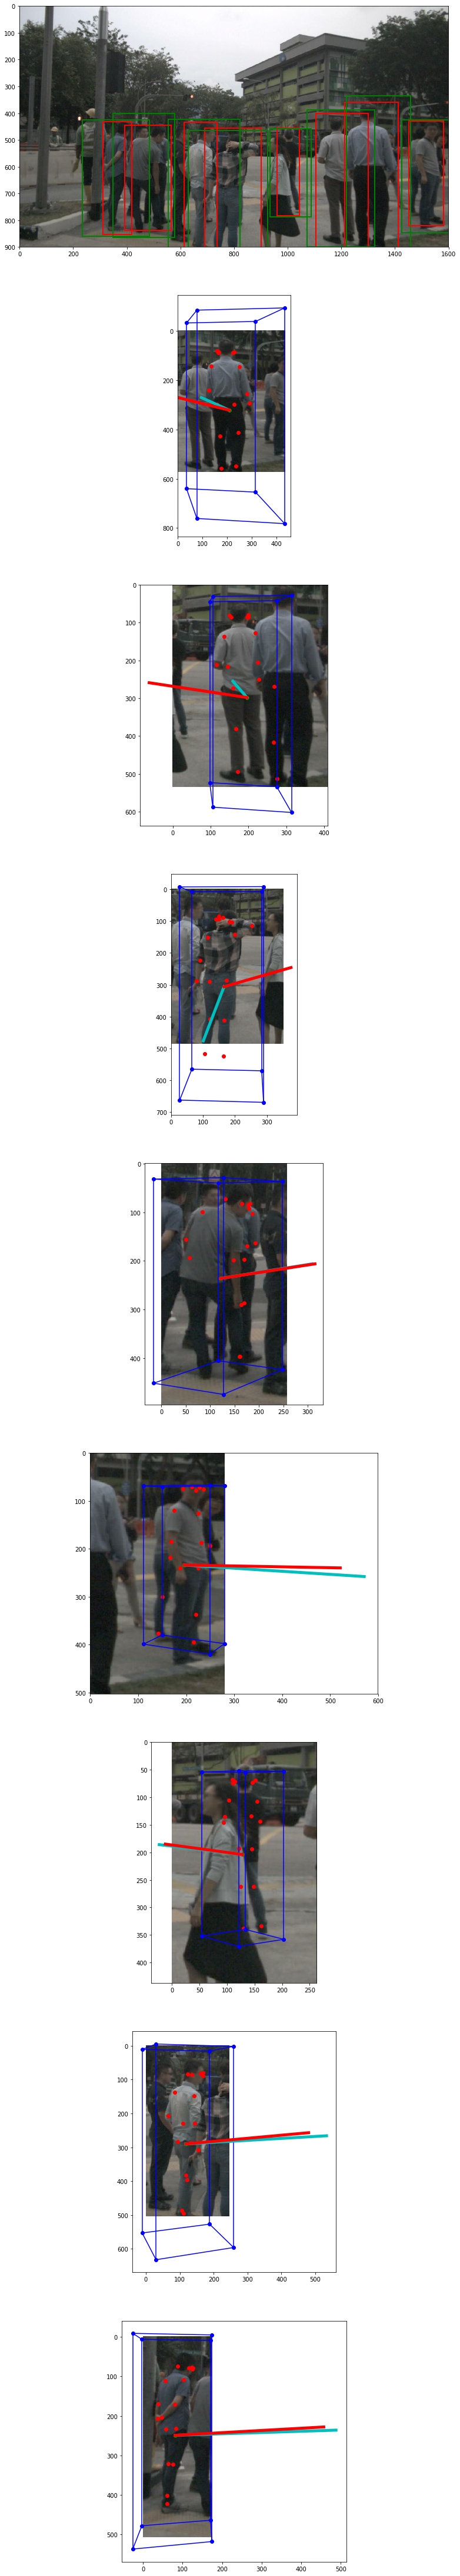

In [205]:
show_3d_multi(pedestrian['filepath'])

In [231]:
pedestrian = test_data[9263]

In [232]:
print(np.round(pedestrian['orientation'],2), np.round(pedestrian['position'],2), np.round(pedestrian['dimensions'],2))
        
print(np.round(pedestrian['pred_orient'],2), np.round(pedestrian['naive_pos'],2), np.round(pedestrian['pred_dim'],2))


166.61 [-0.44  0.58  3.84] [0.48 0.5  1.71]
162.54 [-0.5   0.66  4.45] [0.57 0.55 1.67]


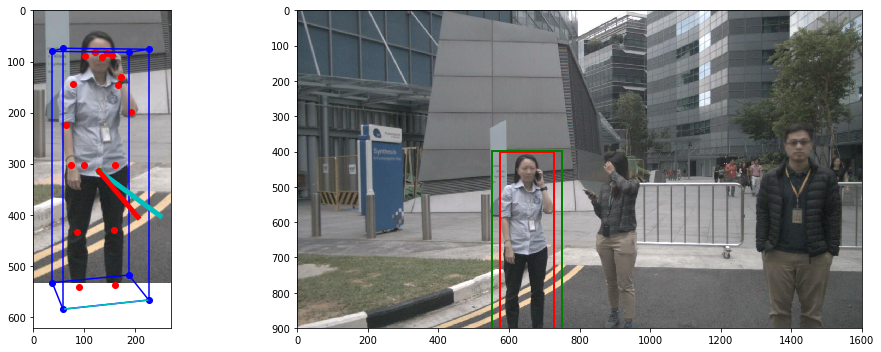

In [233]:
show_3d(pedestrian)

In [79]:
np.corrcoef(np.array([errors_angles, errors_dim, errors_pos]))

array([[1.        , 0.03712478, 0.10794325],
       [0.03712478, 1.        , 0.08295677],
       [0.10794325, 0.08295677, 1.        ]])